# Libraries

In [17]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

import optuna
import xgboost as xgb

import os
import joblib

C:\Users\firma\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset

In [2]:
df_train = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/REGRESSION/CRAB AGE/ML/Data/train.csv')
df_test = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/REGRESSION/CRAB AGE/ML/Data/test.csv')
df_sample = pd.read_csv('C:/Users/firma/Documents/Python/ML + BE/REGRESSION/CRAB AGE/ML/Data/sample_submission.csv')

# Data Information

## Train

In [3]:
df_train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [5]:
obj = [col for col in df_train.columns if df_train[col].nunique() <= 10]
for col in obj:
   print(f"Column: {col}")
   print(f"Number of Unique Values (nunique): {df_train[col].nunique()}")
   print(f"Unique Values: {df_train[col].unique()}")
   print("Value Counts:")
   print(df_train[col].value_counts())
   print("-" * 50)

Column: Sex
Number of Unique Values (nunique): 3
Unique Values: ['I' 'M' 'F']
Value Counts:
Sex
M    27084
I    23957
F    23010
Name: count, dtype: int64
--------------------------------------------------


## Test

In [6]:
df_test.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49368 entries, 0 to 49367
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              49368 non-null  int64  
 1   Sex             49368 non-null  object 
 2   Length          49368 non-null  float64
 3   Diameter        49368 non-null  float64
 4   Height          49368 non-null  float64
 5   Weight          49368 non-null  float64
 6   Shucked Weight  49368 non-null  float64
 7   Viscera Weight  49368 non-null  float64
 8   Shell Weight    49368 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.4+ MB


In [8]:
obj = [col for col in df_test.columns if df_test[col].nunique() <= 10]
for col in obj:
   print(f"Column: {col}")
   print(f"Number of Unique Values (nunique): {df_test[col].nunique()}")
   print(f"Unique Values: {df_test[col].unique()}")
   print("Value Counts:")
   print(df_test[col].value_counts())
   print("-" * 50)

Column: Sex
Number of Unique Values (nunique): 3
Unique Values: ['I' 'F' 'M']
Value Counts:
Sex
M    17923
I    15963
F    15482
Name: count, dtype: int64
--------------------------------------------------


# Exploratory Data Analysis

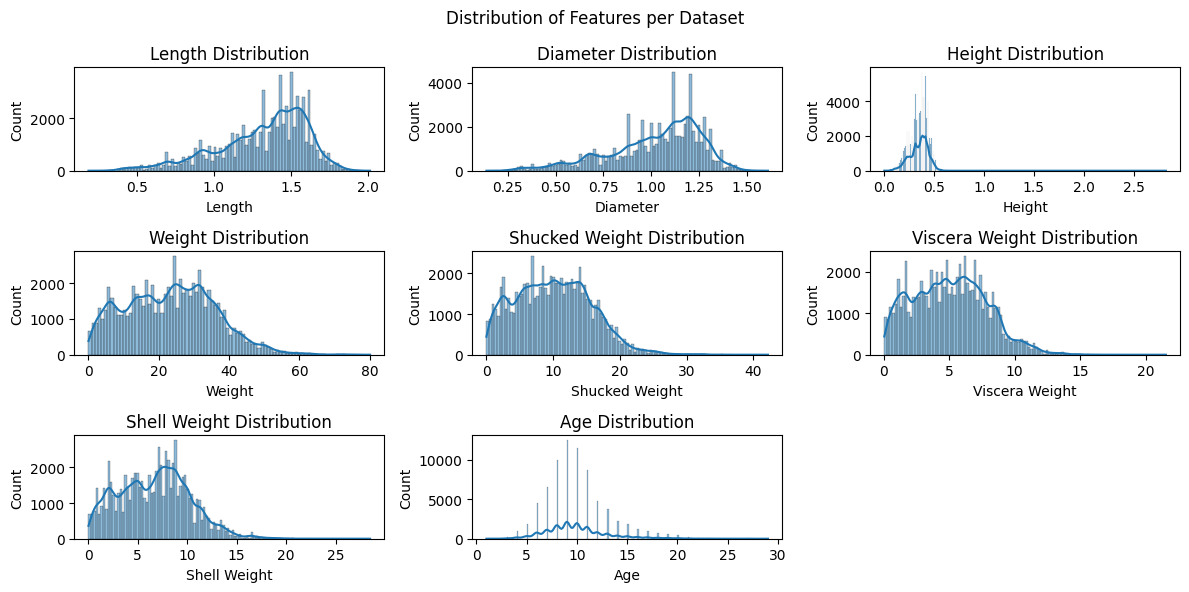

In [9]:
num_cols = [col for col in df_train.columns if df_train[col].dtype in ['float64', 'int64'] and col not in ['id']]
fig, axes = plt.subplots(3,3, figsize = (12,6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  ax = sns.histplot(data=df_train, x=col, ax=axes[i], kde=True)
  ax.set_title(f'{col} Distribution')
  ax.set_xlabel(f'{col}')

for j in range(i+1, len(axes)):
  fig.delaxes(axes[j])

fig.suptitle('Distribution of Features per Dataset')
plt.tight_layout()
plt.show()

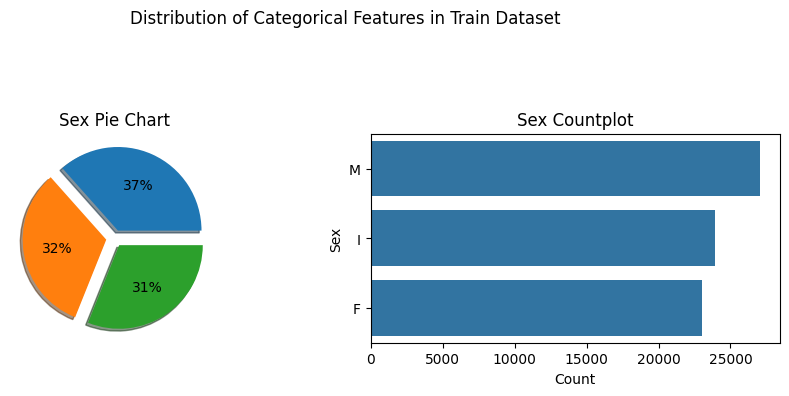

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

ax = axes[0]
ax.pie(
    df_train['Sex'].value_counts(),
    shadow=True,
    explode=[0.1 for _ in range(df_train['Sex'].nunique())],
    autopct='%1.f%%'
)
ax.set_aspect('equal')
ax.set_title('Sex Pie Chart')

ax1 = axes[1]
sns.countplot(
    y='Sex',
    ax=ax1,
    order=df_train['Sex'].value_counts().index,
    data=df_train
)
ax1.set_xlabel('Count')
ax1.set_ylabel('Sex')
ax1.set_title('Sex Countplot')

fig.suptitle('Distribution of Categorical Features in Train Dataset\n\n\n')

plt.tight_layout()
plt.show()

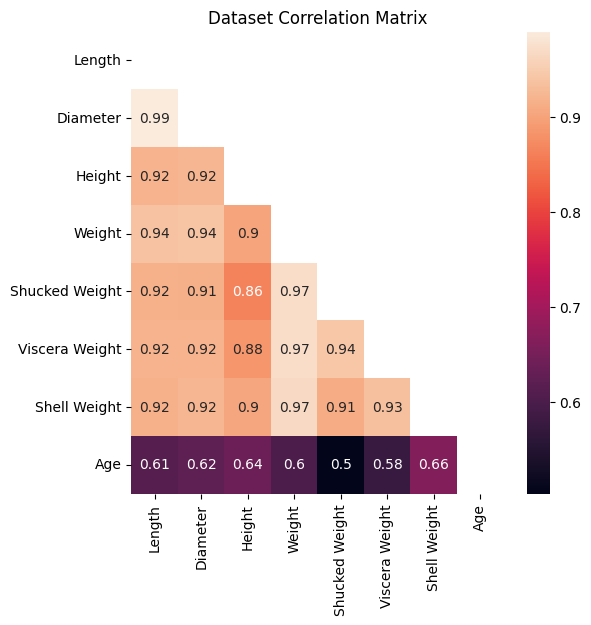

In [11]:
columns = [col for col in df_train.columns if df_train[col].dtype in ['int64', 'float64'] and col not in ['id']]

corr = df_train[columns].corr()
plt.figure(figsize=(6, 6))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.title('Dataset Correlation Matrix')
plt.show()

# Data Preprocessing

In [ ]:
le = LabelEncoder()
df_train['Sex'] = le.fit_transform(df_train['Sex'])
df_test['Sex'] = le.fit_transform(df_test['Sex'])

In [14]:
df_train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,1,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,0,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,1,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


# Data Modeling

## Train Test Split

In [15]:
features = [col for col in df_train.columns if col not in ['id','Age']]
target = 'Age'

In [16]:
X = df_train[features]
y = df_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Cross validation

In [19]:
def crossval(model, X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    mae_scores = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print(f"Fold {fold + 1}: MSE = {mse:.4f}, MAE = {mae:.4f}")
        mse_scores.append(mse)
        mae_scores.append(mae)

    print(f"\nAverage MSE: {np.mean(mse_scores):.4f}")
    print(f"Average MAE: {np.mean(mae_scores):.4f}")
    
    return {'mse': mse_scores, 'mae': mae_scores}

## Hyperparameter

In [23]:
def objective_xgb_params(trial):
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
        'random_state': 42,
        'eval_metric': 'rmse',
        'verbosity': 0,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**xgb_params)
    scores = crossval(model, X, y)  
    return -np.mean(scores['mse'])


study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb_params, n_trials=10)

best_params = study.best_params
print("Best parameters:", best_params)


[I 2025-06-25 01:43:56,595] A new study created in memory with name: no-name-bb31ccfa-df99-4338-be5b-67f92bec4cec


Fold 1: MSE = 9.6989, MAE = 2.2398
Fold 2: MSE = 10.1002, MAE = 2.2772
Fold 3: MSE = 9.8991, MAE = 2.2692
Fold 4: MSE = 9.7738, MAE = 2.2670
Fold 5: MSE = 10.0813, MAE = 2.2906
Fold 6: MSE = 9.8093, MAE = 2.2486
Fold 7: MSE = 10.1790, MAE = 2.2880
Fold 8: MSE = 10.1625, MAE = 2.2937
Fold 9: MSE = 9.5163, MAE = 2.2341


[I 2025-06-25 01:44:16,345] Trial 0 finished with value: -9.8854515100316 and parameters: {'max_depth': 8, 'learning_rate': 0.9583291681278427, 'min_child_weight': 6, 'subsample': 0.7067780328496431, 'colsample_bytree': 0.8917433102980666, 'n_estimators': 994}. Best is trial 0 with value: -9.8854515100316.


Fold 10: MSE = 9.6340, MAE = 2.2464

Average MSE: 9.8855
Average MAE: 2.2655
Fold 1: MSE = 4.2922, MAE = 1.4266
Fold 2: MSE = 4.1842, MAE = 1.4134
Fold 3: MSE = 4.2991, MAE = 1.4118
Fold 4: MSE = 4.0992, MAE = 1.4072
Fold 5: MSE = 4.2168, MAE = 1.4052
Fold 6: MSE = 4.2850, MAE = 1.4257
Fold 7: MSE = 4.5295, MAE = 1.4459
Fold 8: MSE = 4.4080, MAE = 1.4398
Fold 9: MSE = 4.0328, MAE = 1.3806


[I 2025-06-25 01:44:21,571] Trial 1 finished with value: -4.265173128668922 and parameters: {'max_depth': 6, 'learning_rate': 0.10516381037261802, 'min_child_weight': 5, 'subsample': 0.4027700882504561, 'colsample_bytree': 0.7268930934457902, 'n_estimators': 370}. Best is trial 1 with value: -4.265173128668922.


Fold 10: MSE = 4.3049, MAE = 1.4124

Average MSE: 4.2652
Average MAE: 1.4169
Fold 1: MSE = 4.9480, MAE = 1.6062
Fold 2: MSE = 4.8225, MAE = 1.5782
Fold 3: MSE = 4.9215, MAE = 1.5897
Fold 4: MSE = 4.7645, MAE = 1.5819
Fold 5: MSE = 4.8341, MAE = 1.5688
Fold 6: MSE = 4.9524, MAE = 1.5994
Fold 7: MSE = 5.1253, MAE = 1.6109
Fold 8: MSE = 5.1076, MAE = 1.6126
Fold 9: MSE = 4.7183, MAE = 1.5692


[I 2025-06-25 01:44:31,483] Trial 2 finished with value: -4.90902293552767 and parameters: {'max_depth': 6, 'learning_rate': 0.748674947817294, 'min_child_weight': 3, 'subsample': 0.07429241395406096, 'colsample_bytree': 0.16746715279507407, 'n_estimators': 939}. Best is trial 1 with value: -4.265173128668922.


Fold 10: MSE = 4.8960, MAE = 1.5752

Average MSE: 4.9090
Average MAE: 1.5892
Fold 1: MSE = 58729553349000372224.0000, MAE = 1380048620.9733
Fold 2: MSE = 46080250009276153856.0000, MAE = 1253442890.7103
Fold 3: MSE = 173922952386346909696.0000, MAE = 2342173014.6510
Fold 4: MSE = 220103422528132120576.0000, MAE = 2677152755.2038
Fold 5: MSE = 217360156635032616960.0000, MAE = 2710182870.3761
Fold 6: MSE = 227501551457373978624.0000, MAE = 2666240667.8674
Fold 7: MSE = 310740533920013811712.0000, MAE = 3039381764.0571
Fold 8: MSE = 230732921018278576128.0000, MAE = 2697431829.0444
Fold 9: MSE = 101806604439593222144.0000, MAE = 1963561251.9464


[I 2025-06-25 01:44:45,905] Trial 3 finished with value: -1.764710918401692e+20 and parameters: {'max_depth': 7, 'learning_rate': 0.9993669481979882, 'min_child_weight': 8, 'subsample': 0.15903911937068635, 'colsample_bytree': 0.7997244929054823, 'n_estimators': 978}. Best is trial 1 with value: -4.265173128668922.


Fold 10: MSE = 177732972658644615168.0000, MAE = 2380255073.0745

Average MSE: 176471091840169213952.0000
Average MAE: 2310987073.7904
Fold 1: MSE = 4.1584, MAE = 1.4095
Fold 2: MSE = 4.1033, MAE = 1.3965
Fold 3: MSE = 4.1612, MAE = 1.3930
Fold 4: MSE = 4.0127, MAE = 1.3915
Fold 5: MSE = 4.0949, MAE = 1.3878
Fold 6: MSE = 4.1684, MAE = 1.4053
Fold 7: MSE = 4.4247, MAE = 1.4314
Fold 8: MSE = 4.3462, MAE = 1.4288
Fold 9: MSE = 3.9488, MAE = 1.3646


[I 2025-06-25 01:44:52,203] Trial 4 finished with value: -4.162671132976179 and parameters: {'max_depth': 5, 'learning_rate': 0.041967322511193485, 'min_child_weight': 2, 'subsample': 0.7721566754754218, 'colsample_bytree': 0.894176388678727, 'n_estimators': 459}. Best is trial 4 with value: -4.162671132976179.


Fold 10: MSE = 4.2082, MAE = 1.3930

Average MSE: 4.1627
Average MAE: 1.4001
Fold 1: MSE = 6.8694, MAE = 1.8580
Fold 2: MSE = 6.3905, MAE = 1.7979
Fold 3: MSE = 6.6388, MAE = 1.8210
Fold 4: MSE = 6.4296, MAE = 1.7938
Fold 5: MSE = 6.6082, MAE = 1.8218
Fold 6: MSE = 6.8329, MAE = 1.8436
Fold 7: MSE = 6.7930, MAE = 1.8476
Fold 8: MSE = 6.6315, MAE = 1.8240
Fold 9: MSE = 6.4057, MAE = 1.7951


[I 2025-06-25 01:45:09,044] Trial 5 finished with value: -6.620650294273778 and parameters: {'max_depth': 9, 'learning_rate': 0.39535128072628173, 'min_child_weight': 10, 'subsample': 0.4249320846361902, 'colsample_bytree': 0.524419053600406, 'n_estimators': 641}. Best is trial 4 with value: -4.162671132976179.


Fold 10: MSE = 6.6069, MAE = 1.8267

Average MSE: 6.6207
Average MAE: 1.8229
Fold 1: MSE = 4.3357, MAE = 1.4384
Fold 2: MSE = 4.2219, MAE = 1.4221
Fold 3: MSE = 4.3672, MAE = 1.4326
Fold 4: MSE = 4.1369, MAE = 1.4197
Fold 5: MSE = 4.2150, MAE = 1.4130
Fold 6: MSE = 4.3153, MAE = 1.4358
Fold 7: MSE = 4.5639, MAE = 1.4595
Fold 8: MSE = 4.4425, MAE = 1.4462
Fold 9: MSE = 4.1064, MAE = 1.3982


[I 2025-06-25 01:45:15,822] Trial 6 finished with value: -4.306646597633124 and parameters: {'max_depth': 10, 'learning_rate': 0.09984179642966137, 'min_child_weight': 9, 'subsample': 0.8218707016938601, 'colsample_bytree': 0.40799866531347484, 'n_estimators': 196}. Best is trial 4 with value: -4.162671132976179.


Fold 10: MSE = 4.3618, MAE = 1.4230

Average MSE: 4.3066
Average MAE: 1.4288
Fold 1: MSE = 4.1776, MAE = 1.4113
Fold 2: MSE = 4.1076, MAE = 1.3990
Fold 3: MSE = 4.1552, MAE = 1.3930
Fold 4: MSE = 4.0312, MAE = 1.3949
Fold 5: MSE = 4.0905, MAE = 1.3877
Fold 6: MSE = 4.1651, MAE = 1.4071
Fold 7: MSE = 4.4160, MAE = 1.4314
Fold 8: MSE = 4.3535, MAE = 1.4276
Fold 9: MSE = 3.9423, MAE = 1.3653


[I 2025-06-25 01:45:20,145] Trial 7 finished with value: -4.164731954798759 and parameters: {'max_depth': 5, 'learning_rate': 0.04917483930580263, 'min_child_weight': 2, 'subsample': 0.7533120175364496, 'colsample_bytree': 0.8558668434757294, 'n_estimators': 298}. Best is trial 4 with value: -4.162671132976179.


Fold 10: MSE = 4.2083, MAE = 1.3928

Average MSE: 4.1647
Average MAE: 1.4010
Fold 1: MSE = 4.9106, MAE = 1.5393
Fold 2: MSE = 4.8184, MAE = 1.5242
Fold 3: MSE = 4.9596, MAE = 1.5408
Fold 4: MSE = 4.7186, MAE = 1.5116
Fold 5: MSE = 4.8039, MAE = 1.5138
Fold 6: MSE = 4.9374, MAE = 1.5378
Fold 7: MSE = 5.1930, MAE = 1.5757
Fold 8: MSE = 4.9904, MAE = 1.5390
Fold 9: MSE = 4.6906, MAE = 1.5059


[I 2025-06-25 01:45:36,399] Trial 8 finished with value: -4.895217898631411 and parameters: {'max_depth': 8, 'learning_rate': 0.266120060828784, 'min_child_weight': 6, 'subsample': 0.9829734717208535, 'colsample_bytree': 0.8439680177211685, 'n_estimators': 758}. Best is trial 4 with value: -4.162671132976179.


Fold 10: MSE = 4.9297, MAE = 1.5242

Average MSE: 4.8952
Average MAE: 1.5312
Fold 1: MSE = 4.5365, MAE = 1.4989
Fold 2: MSE = 4.3920, MAE = 1.4808
Fold 3: MSE = 4.5145, MAE = 1.4861
Fold 4: MSE = 4.4132, MAE = 1.4863
Fold 5: MSE = 4.4126, MAE = 1.4653
Fold 6: MSE = 4.4801, MAE = 1.4989
Fold 7: MSE = 4.7451, MAE = 1.5154
Fold 8: MSE = 4.7439, MAE = 1.5169
Fold 9: MSE = 4.3323, MAE = 1.4555


[I 2025-06-25 01:45:41,969] Trial 9 finished with value: -4.51836989793371 and parameters: {'max_depth': 6, 'learning_rate': 0.43699073558690904, 'min_child_weight': 9, 'subsample': 0.8516419586308897, 'colsample_bytree': 0.11612825410818921, 'n_estimators': 326}. Best is trial 4 with value: -4.162671132976179.


Fold 10: MSE = 4.6134, MAE = 1.4881

Average MSE: 4.5184
Average MAE: 1.4892
Best parameters: {'max_depth': 5, 'learning_rate': 0.041967322511193485, 'min_child_weight': 2, 'subsample': 0.7721566754754218, 'colsample_bytree': 0.894176388678727, 'n_estimators': 459}


In [25]:
final_XGB_params = {
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],  
    'n_estimators': best_params['n_estimators'],
    'min_child_weight': best_params['min_child_weight'],
    'colsample_bytree': best_params['colsample_bytree'],
    'subsample': best_params['subsample'],
    'eval_metric': 'rmse',
    'random_state': 42,
    'verbosity': 2,
    'n_jobs': -1
}

final_model = xgb.XGBRegressor(**final_XGB_params)

scores = crossval(model=final_model, X=X, y=y)


[01:46:34] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (66645, 8, 533160).
Fold 1: MSE = 4.1584, MAE = 1.4095
[01:46:35] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (66646, 8, 533168).
Fold 2: MSE = 4.1033, MAE = 1.3965
[01:46:35] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (66646, 8, 533168).
Fold 3: MSE = 4.1612, MAE = 1.3930
[01:46:36] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (66646, 8, 533168).
Fold 4: MSE = 4.0127, MAE = 1.3915
[01:46:36] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (66646, 8, 533168).
Fold 5: MSE = 4.0949, MAE = 1.3878
[01:46:37] INFO: C:\actions-runner\_work

# Model Evaluation

In [26]:
best_model = xgb.XGBRegressor(**final_XGB_params)
best_model.fit(X_train, y_train)

[01:46:47] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (59240, 8, 473920).


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.894176388678727, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041967322511193485,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=459, n_jobs=-1,
             num_parallel_tree=None, ...)

In [27]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test MSE: 4.0631
Test MAE: 1.3782


In [34]:
os.makedirs('ML/Model', exist_ok=True)

joblib.dump(best_model, '../Model/xgb_regressor_model.pkl')

['../Model/xgb_regressor_model.pkl']

# Predict

In [32]:
y_pred = best_model.predict(df_test[features])
df_sample['Age'] = y_pred
df_sample.head()

,id,Age
0,74051,7.536148
1,74052,7.771930
2,74053,11.138988
3,74054,9.492367
4,74055,7.468910
